In [35]:
from sage.all import *
import matplotlib.pyplot as plt
import time
import hashlib
import numpy as np
import pandas as pd
from random import sample
from tqdm.std import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial

In [33]:
class McElieceKEM:
    def __init__(self, r=3):
        """
        Initialize McEliece with Hamming Code parameters using SageMath.
        r: Rank of the parity check matrix (Hamming code H(r))
        """
        self.r = r
        # Create Hamming code code object
        self.C = codes.HammingCode(GF(2), r)
        self.n = self.C.length()
        self.k = self.C.dimension()
        self.t = 1 # Hamming code error correction capability
        
        self.pub_key_G_hat = None
        self.priv_key = None
        
    def keygen(self):
        """
        Generate Public and Private Keys.
        Public: G_hat = S * G * P
        Private: S, G, P, Decoder
        Returns: keygen_time (seconds)
        """
        start_time = time.time()
        #print(f"Generating keys for parameters n={self.n}, k={self.k}, t={self.t}...")
        
        # 1. Get Generator Matrix G (k x n)
        G = self.C.generator_matrix()
        
        # 2. Generate S (k x k non-singular)
        # SageMath has efficient methods for random invertible matrices
        S = matrix(GF(2), self.k, self.k)
        while True:
            S = random_matrix(GF(2), self.k, self.k)
            if S.is_invertible():
                break
                
        # 3. Generate P (n x n permutation)
        # Create a random permutation and convert to matrix
        perm = Permutations(self.n).random_element()
        P = perm.to_matrix().change_ring(GF(2)) # Sage permutation matrix
        
        # 4. Compute G_hat = S * G * P
        G_hat = S * G * P
        
        self.pub_key_G_hat = G_hat
        self.priv_key = {
            'S': S,
            'P': P,
            'G': G,
            'perm': perm # Keeping the permutation object can be useful
        }
        
        end_time = time.time()
        return end_time - start_time

    def encapsulation(self, error_weight=None):
        """
        Generate a shared secret and a ciphertext.
        c = m * G_hat + e
        K = Hash(m)
        error_weight: number of error bits to flip (default: 1 for Hamming)
        Returns: (ciphertext, key_hex, encaps_time)
        """
        if self.pub_key_G_hat is None:
            raise ValueError("Keys not generated")
            
        start_time = time.time()
        
        # 1. Generate random message m (vector of length k)
        m = random_vector(GF(2), self.k)
        
        # 2. Encode: c_prime = m * G_hat
        c_prime = m * self.pub_key_G_hat
        
        # 3. Add error vector e of weight t (Hamming: t=1 by default)
        w = self.t if error_weight is None else int(error_weight)
        w = max(0, min(w, self.n))
        e = vector(GF(2), self.n * [0])
        if w > 0:
            # choose w distinct positions
            idxs = sample(range(self.n), w)
            for i in idxs:
                e[i] = 1
        
        ciphertext = c_prime + e
        
        # 4. Derive Key K = H(m)
        m_bytes = bytes(list(m)) # Simple conversion for bit vector
        key = hashlib.sha256(m_bytes).hexdigest()
        
        end_time = time.time()
        return ciphertext, key, end_time - start_time

    def decapsulation(self, ciphertext):
        """
        Recover the shared secret from ciphertext.
        y P^-1 = m S G + e P^-1
        Decode -> m S -> m
        Returns: (key_hex, decapsulation_time)
        """
        if self.priv_key is None:
            raise ValueError("Keys not generated")
            
        start_time = time.time()
        
        S = self.priv_key['S']
        P = self.priv_key['P']
        
        # 1. c_hat = ciphertext * P^-1 (for permutation matrices, inverse is transpose)
        c_hat = ciphertext * P.inverse()
        
        # 2. Decode c_hat to get codeword c_corr = (m S) * G
        try:
            c_corr = self.C.decode_to_code(c_hat)
        except DecodingError:
            return None, 0 # Key recovery failed
            
        # 3. Extract message 'mS' from codeword c_corr where c_corr = (m S) * G
        # Use an information set approach to invert the generator mapping
        G = self.C.generator_matrix()
        I = self.C.information_set()  # indices of an information set (size k)
        # Submatrix G_I (k x k) is invertible
        G_I = G.matrix_from_columns(I)
        # Take codeword positions at the information set
        c_I = vector(GF(2), [c_corr[i] for i in I])
        # Recover mS as c_I * G_I^{-1}
        mS = c_I * G_I.inverse()
        
        # 4. Recover m = mS * S^-1
        m = mS * S.inverse()
        
        # 5. Derive Key
        m_bytes = bytes(list(m))
        key = hashlib.sha256(m_bytes).hexdigest()
        
        end_time = time.time()
        return key, end_time - start_time

# Test the implementation
print("Testing Implementation with r=3...")
kem = McElieceKEM(r=3)
kem.keygen()
c, k1, _ = kem.encapsulation()
k2, _ = kem.decapsulation(c)

print("Key 1:", k1)
print("Key 2:", k2)
print("Match:", k1 == k2)

Testing Implementation with r=3...
Key 1: 252c0b6b080fa045acfcd1437f693f3be2be2ac8223ea525d492fa19ab028942
Key 2: 252c0b6b080fa045acfcd1437f693f3be2be2ac8223ea525d492fa19ab028942
Match: True



--- Running Performance Test ---

Generating keys for parameters n=7, k=4, t=1...
r=3 (n=7): KG=0.0030s, Enc=0.0002s, Dec=0.0016s
Generating keys for parameters n=15, k=11, t=1...
r=4 (n=15): KG=0.0054s, Enc=0.0004s, Dec=0.0010s
Generating keys for parameters n=31, k=26, t=1...
r=5 (n=31): KG=0.0065s, Enc=0.0003s, Dec=0.0019s
Generating keys for parameters n=63, k=57, t=1...
r=6 (n=63): KG=0.0034s, Enc=0.0004s, Dec=0.0055s
Generating keys for parameters n=127, k=120, t=1...
r=7 (n=127): KG=0.0088s, Enc=0.0009s, Dec=0.0217s


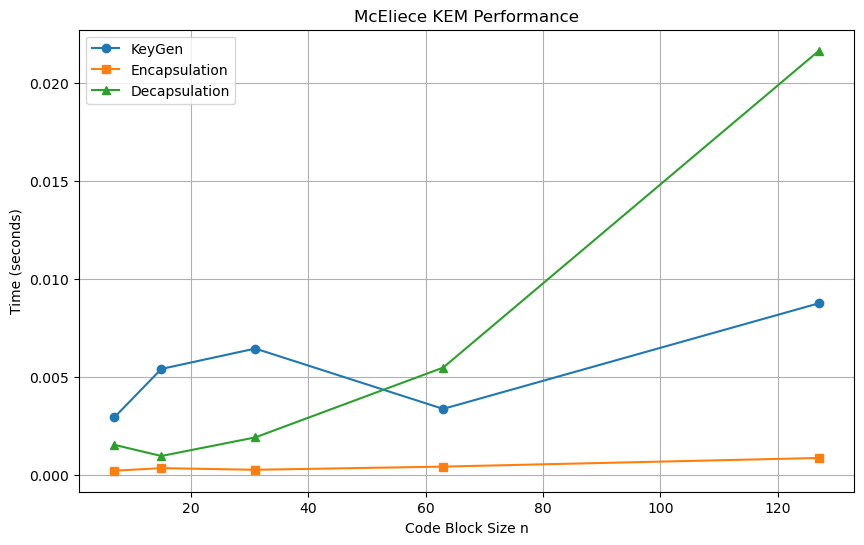

In [17]:
# --- Performance Analysis ---

def run_sage_performance_test():
    print("\n--- Running Performance Test ---\n")
    
    # Hamming code n = 2^r - 1
    # We test r = 3, 4, 5, 6, 7 (n=7 to 127)
    # Note: larger matricies might take slightly longer
    r_values = [3, 4, 5, 6, 7]
    results = []
    
    for r in r_values:
        kem = McElieceKEM(r)
        
        # Measure KeyGen
        t_kg = kem.keygen()
        
        # Measure Encap
        # Average over small number of runs
        t_enc_sum = 0
        t_dec_sum = 0
        trials = 10
        
        for _ in range(trials):
            c, k_enc, t_e = kem.encapsulation()
            k_dec, t_d = kem.decapsulation(c)
            t_enc_sum += t_e
            t_dec_sum += t_d
            
            if k_enc != k_dec:
                print(f"Error in Decryption at r={r}!")
        
        results.append({
            'r': r,
            'n': kem.n,
            'k': kem.k,
            'keygen': t_kg,
            'encap': t_enc_sum / trials,
            'decap': t_dec_sum / trials
        })
        
        print(f"r={r} (n={kem.n}): KG={t_kg:.4f}s, Enc={t_enc_sum/trials:.4f}s, Dec={t_dec_sum/trials:.4f}s")
        
    return results

def plot_sage_results(results):
    ns = [res['n'] for res in results]
    t_kg = [res['keygen'] for res in results]
    t_enc = [res['encap'] for res in results]
    t_dec = [res['decap'] for res in results]
    
    plt.figure(figsize=(10, 6))
    plt.plot(ns, t_kg, 'o-', label='KeyGen')
    plt.plot(ns, t_enc, 's-', label='Encapsulation')
    plt.plot(ns, t_dec, '^-', label='Decapsulation')
    
    plt.xlabel('Code Block Size n')
    plt.ylabel('Time (seconds)')
    plt.title('McEliece KEM Performance')
    plt.legend()
    plt.grid(True)
    plt.show() # Shows plot if supported by environment
    
# To run the test, uncomment the following line in a SageMath environment
results = run_sage_performance_test()
plot_sage_results(results)



--- Running Parameter Sweep (simple, parallel) ---

r values: [3, 4, 5, 6, 7, 8, 9, 10]
keys_per_r: 3, trials_per_key: 10, error_weights: [0, 1, 2]
parallel workers: 4

[1/24] r= 4 | key#0 | n=   15 | KG= 0.1302s | completed
[2/24] r= 3 | key#2 | n=    7 | KG= 0.1296s | completed
[3/24] r= 3 | key#0 | n=    7 | KG= 0.1297s | completed
[4/24] r= 3 | key#1 | n=    7 | KG= 0.1295s | completed
[5/24] r= 4 | key#2 | n=   15 | KG= 0.0023s | completed
[6/24] r= 4 | key#1 | n=   15 | KG= 0.0071s | completed
[7/24] r= 5 | key#1 | n=   31 | KG= 0.0135s | completed
[8/24] r= 5 | key#0 | n=   31 | KG= 0.0146s | completed
[9/24] r= 5 | key#2 | n=   31 | KG= 0.0065s | completed
[10/24] r= 6 | key#2 | n=   63 | KG= 0.0069s | completed
[11/24] r= 6 | key#0 | n=   63 | KG= 0.0179s | completed
[12/24] r= 6 | key#1 | n=   63 | KG= 0.0113s | completed
[13/24] r= 7 | key#0 | n=  127 | KG= 0.0511s | completed
[14/24] r= 7 | key#2 | n=  127 | KG= 0.0193s | completed
[15/24] r= 7 | key#1 | n=  127 | KG= 0.01

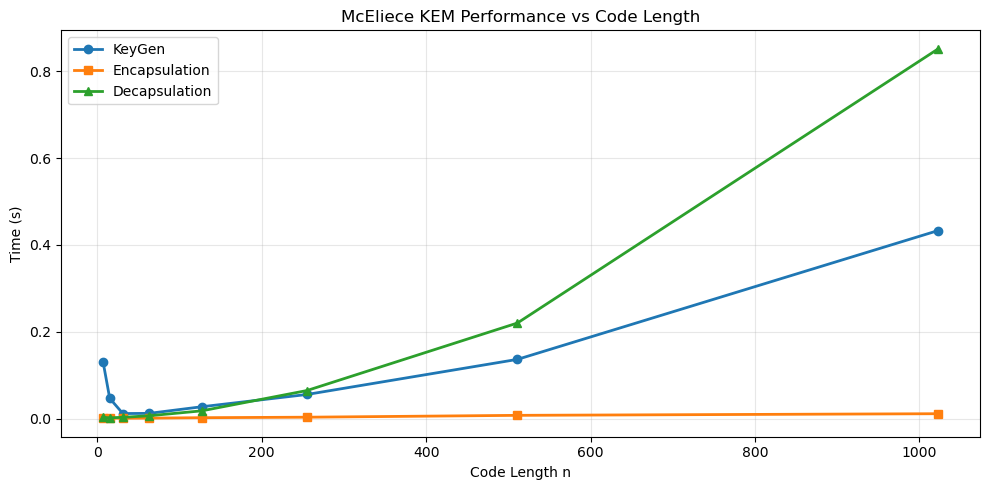

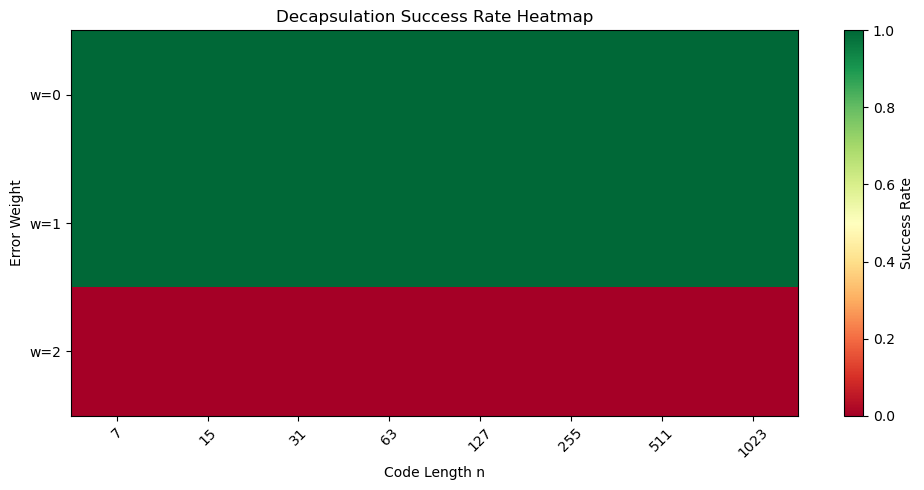

In [39]:
def _run_single_config(r, key_idx, error_weights, trials_per_key):
    """Worker function to run one configuration in parallel."""
    kem = McElieceKEM(r)
    n_val = kem.n
    k_val = kem.k
    
    t_keygen = kem.keygen()
    
    config_results = []
    for w in error_weights:
        t_enc_sum = 0.0
        t_dec_sum = 0.0
        successes = 0
        used_w = int(w)
        
        for _ in range(trials_per_key):
            try:
                c, k_enc, t_e = kem.encapsulation(error_weight=w)
            except TypeError:
                c, k_enc, t_e = kem.encapsulation()
                used_w = kem.t
            
            t_enc_sum += t_e
            
            k_dec, t_d = kem.decapsulation(c)
            t_dec_sum += t_d
            
            if k_dec is not None and k_enc == k_dec:
                successes += 1
        
        avg_enc = t_enc_sum / trials_per_key
        avg_dec = t_dec_sum / trials_per_key
        success_rate = float(successes) / float(trials_per_key)
        
        config_results.append({
            'r': int(r),
            'n': int(n_val),
            'k': int(k_val),
            'key_index': int(key_idx),
            'error_weight': int(used_w),
            'keygen_time': float(t_keygen),
            'encaps_time': float(avg_enc),
            'decaps_time': float(avg_dec),
            'success_rate': float(success_rate),
            'trials_per_key': int(trials_per_key),
        })
    
    return config_results


def run_parameter_sweep_simple(
    r_values=None,
    keys_per_r=3,
    trials_per_key=10,
    error_weights=(0, 1),
    seed=None,
    n_jobs=4
):
    """
    Extend the working run_sage_performance_test into a parameter sweep.
    - r_values: list of Hamming r (controls n = 2^r - 1). Defaults to [3..10].
    - keys_per_r: number of fresh KeyGen runs per r
    - trials_per_key: number of Encaps/Decaps trials per key
    - error_weights: iterable of error weights (Hamming corrects w<=1)
    - seed: optional Sage RNG seed for reproducibility
    - n_jobs: number of parallel workers (default: 4)

    Returns: list of result dicts with averages and success_rate.
    """
    if r_values is None:
        r_values = [3, 4, 5, 6, 7, 8, 9, 10]

    if seed is not None:
        try:
            set_random_seed(seed)
        except Exception:
            pass

    print("\n--- Running Parameter Sweep (simple, parallel) ---\n")
    print(f"r values: {r_values}")
    print(f"keys_per_r: {keys_per_r}, trials_per_key: {trials_per_key}, error_weights: {list(error_weights)}")
    print(f"parallel workers: {n_jobs}\n")

    # Generate all configurations
    configs = [(r, key_idx) for r in r_values for key_idx in range(keys_per_r)]
    total_configs = len(configs)
    
    results = []
    
    # Use ProcessPoolExecutor for parallel execution
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        # Submit all tasks
        future_to_config = {
            executor.submit(_run_single_config, r, key_idx, error_weights, trials_per_key): (r, key_idx)
            for r, key_idx in configs
        }
        
        # Process completed tasks with simple progress tracking
        completed = 0
        for future in as_completed(future_to_config):
            r, key_idx = future_to_config[future]
            try:
                config_results = future.result()
                results.extend(config_results)
                
                completed += 1
                # Print summary for first result of this config
                if config_results:
                    res = config_results[0]
                    print(
                        f"[{completed}/{total_configs}] r={int(r):2d} | key#{int(key_idx)} | n={int(res['n']):5d} | "
                        f"KG={float(res['keygen_time']):7.4f}s | completed"
                    )
            except Exception as e:
                completed += 1
                print(f"[{completed}/{total_configs}] Error processing r={r}, key#{key_idx}: {e}")
    
    return results


def save_and_plot_sweep(results, csv_name="mceliece_hamming_sweep_simple.csv"):
    df = pd.DataFrame(results)
    df.to_csv(csv_name, index=False)
    print(f"\nResults saved to {csv_name}")

    # Aggregate average times by n
    agg = df.groupby('n', as_index=False).agg({
        'keygen_time': 'mean',
        'encaps_time': 'mean',
        'decaps_time': 'mean'
    })

    # Single plot with three lines for timing
    plt.figure(figsize=(10, 5))
    plt.plot(agg['n'], agg['keygen_time'], 'o-', label='KeyGen', linewidth=2)
    plt.plot(agg['n'], agg['encaps_time'], 's-', label='Encapsulation', linewidth=2)
    plt.plot(agg['n'], agg['decaps_time'], '^-', label='Decapsulation', linewidth=2)
    plt.title('McEliece KEM Performance vs Code Length')
    plt.xlabel('Code Length n')
    plt.ylabel('Time (s)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Success rate heatmap across r, n, and error weight
    pivot_data = df.pivot_table(
        values='success_rate',
        index='error_weight',
        columns='n',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(10, 5))
    plt.imshow(pivot_data, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1, interpolation='nearest')
    plt.colorbar(label='Success Rate')
    plt.yticks(range(len(pivot_data.index)), [f'w={int(w)}' for w in pivot_data.index])
    plt.xticks(range(len(pivot_data.columns)), [int(n) for n in pivot_data.columns], rotation=45)
    plt.xlabel('Code Length n')
    plt.ylabel('Error Weight')
    plt.title('Decapsulation Success Rate Heatmap')
    plt.tight_layout()
    plt.show()


# Example run (adjust as needed)
simple_results = run_parameter_sweep_simple(
    r_values=[3,4,5,6,7,8,9,10],
    keys_per_r=3,
    trials_per_key=10,
    error_weights=(0,1,2),  # test w=0,1 (correctable) and w=2,3 (beyond Hamming capability)
    seed=12345,
    n_jobs=4  # parallel workers
)
save_and_plot_sweep(simple_results, csv_name="mceliece_hamming_sweep_simple.csv")
